In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error 
from qiskit_aer import AerSimulator
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer
try:
    from qiskit_ionq import IonQProvider
except (ImportError):
    %pip install qiskit-ionq
    from qiskit_ionq import IonQProvider


from qiskit.circuit.quantumcircuit import _compare_parameters as cp

from scipy.optimize import minimize

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
TOKEN = next[:len(next)-1]
next = f.readline()
TOKEN_IONQ = next[:len(next)-1]
f.close()


In [2]:
# Setting hyper-parameters of the model: high-level parameters that determine the system we are solving

n_qubits = 3 
n_shots = 10 ** 3
tot_qubits = n_qubits + 1
ancilla_indx = n_qubits # We are using the last qubit to be the ancilla here
steps = 50 # Number of optimization steps
eta = 0.8 # "Learning rate" which is a hyperparameter that is essentially a coefficient attached to the cost 
                # sort of determines what percentage of the optimization of parameters make an effect
q_delta = 0.001 # Initial spread of random quantum weights 
rng_seed = 0 # Seed for random number generator
noisy = False

In [3]:
# Creating the backend and noisemodels 

# Define the basic gate set (1- and 2-qubit gates)
one_qubit_gates = ["x", "h", "s", "sdg", "ry", "rz"]
two_qubit_gates = ["cx"]
basis_gates = one_qubit_gates + two_qubit_gates 
 
## IonQ Aria (25 qubits) fidelity: 
##    1-qubit gates 99.95%, 2-qubit gate 98.95%, SPAM 99.43%
depolar_error_1q_aria = 1.0-0.9995
depolar_error_2q_aria = 1.0-0.9895
spam_error_aria = 1.0-0.9943

## IonQ Harmony (11 qubits) fidelity: 
##    1-qubit gates 99.5%, 2-qubit gate 97.5%, SPAM 99.75%
depolar_error_1q_harmony = 1.0-0.995
depolar_error_2q_harmony = 1.0-0.975
spam_error_harmony = 1.0-0.9975

noise_model_aria = NoiseModel()
noise_model_aria.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_1q_aria, 1), one_qubit_gates)
noise_model_aria.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_2q_aria, 2), two_qubit_gates)
noise_model_aria.add_all_qubit_quantum_error(
    pauli_error([('Z',spam_error_aria), ('I', 1.0-spam_error_aria)] ), "measure")

noise_model_harmony = NoiseModel()
noise_model_harmony.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_1q_harmony, 1), one_qubit_gates)
noise_model_harmony.add_all_qubit_quantum_error(
    depolarizing_error(depolar_error_2q_harmony, 2), two_qubit_gates)
noise_model_harmony.add_all_qubit_quantum_error(
    pauli_error([('Z',spam_error_harmony), ('I', 1.0-spam_error_harmony)] ), "measure")

# Define backends

backend = []
backend_type = []

# backend[0] is the generic, noiseless simulator provided by the Aer wrapper
backend += [Aer.get_backend('aer_simulator')]
backend_type += ["(AerSimulator, generic noiseless)"]

# backend[1] uses the noise model based on the IonQ Aria quantum computer, using the AerSimulator implementation
backend += [AerSimulator(noise_model=noise_model_aria, basis_gates=basis_gates)]
backend_type += ["(AerSimulator, IonQ Aria noise)"]

# backend[2] uses the noise model based on the IonQ Harmony quantum computer, using the AerSimulator implementation
backend += [AerSimulator(noise_model=noise_model_harmony, basis_gates=basis_gates)]
backend_type += ["(AerSimulator, IonQ Harmony noise)"]

# backend[3] uses the IonQ native simulator
provider = IonQProvider(TOKEN_IONQ)
backend += [provider.get_backend('ionq_simulator')]
backend_type += ["(IonQ Simulator, no noise)"]

# backend[4] uses the IonQ Harmony QC
backend += [provider.get_backend('ionq_qpu.harmony')]
backend_type += ["(IonQ Harmony Quantum Computer)"]

# backend[5] uses the IonQ Aria QC
backend += [provider.get_backend('ionq_qpu.aria')]
backend_type += ["(IonQ Harmony Quantum Computer)"]


In [4]:
X_0_Z_1 = [2, 1, 0]
X_0 = [2, 0, 0]
Z_2 = [0, 0, 1]
Z_1 = [0, 1, 0]
I = [0, 0, 0]

# All matrix problems
matrix = [[I, X_0_Z_1, X_0],
                [I, Z_2, Z_1]]

# All coefficient sets
c_all= [[1.0, 0.2, 0.2],
        [0.55, 0.225, 0.225]]

# Current matrix 
m_num = 1

# Current coefficient set of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = c_all[m_num]

SIM = 0

In [5]:
# Defining the unitary operations associated to an example A matrix

# The unitary matrix that prepares a |b> state; |b> = U|0>
# We don't need to find the transpose of this matrix, or even make it 
# a controlled operation since it will be part of the initial state preparation 
# for calculating the expectation value
def U_b():
    for idx in range(n_qubits):
        circ.h(idx) # A hadamard from q_0 to q_{n_qubits-1}, where the final qubit is the control

# This function defines a controlled decomposition of the A matrix into
# corresponding controlled gate sequences. The gate_type parameter takes
# in an array of up to n_qubits elements, where the nth element of the array
# defines the controlled operation on the nth qubit. The exact descriptors are
# shown below:
# 
# 0: Identity gate, no action.
# 1: controlled-Z gate
# 2: controlled-X (CNOT ) gate
def CA_exp(gate_type):
    for i in range(len(gate_type)):
        if gate_type[i] == 1:
            circ.cz(ancilla_indx, i)
        elif gate_type[i] == 2:
            circ.cx(ancilla_indx, i)

# A wrapper function for CA_exp that deals with multiple matrix 
# problems 
def CA(idx):
    CA_exp(matrix[m_num][idx])



In [6]:
# Variational quantum circuit that prepares a solutions state |x> = V(k)|0>
# This block is prepared, not controlled.
def variational_block(weights):

    U_b()

    # First layer of rotation gates
    for idx, element in enumerate(weights[0:3]):
        circ.ry(element, idx)
    
    # Using CNOT gates to entangle wires
    circ.cz(0, 1)
    circ.cz(0, 2)

    # Second layer of rotation gates
    for idx, element in enumerate(weights[3:6]):
        circ.ry(element, idx)

    # Using CNOT gates to entangle wires
    circ.cz(1, 0)
    circ.cz(1, 2)

    # Third layer of rotation gates
    for idx, element in enumerate(weights[6:9]):
        circ.ry(element, idx)


In [7]:
# Hadamard Test
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    global circ
    
    q_reg = QuantumRegister(4)
    c_reg = ClassicalRegister(1)
    circ = QuantumCircuit(q_reg, c_reg)

    # First Hadamard gate applied to the ancillary qubit
    circ.h(ancilla_indx)

    #For estimating the imaginary part of the coefficient "mu", we must add an "-i"
    # phase gate
    if part.lower() == "im":
        circ.p(-np.pi / 2, ancilla_indx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>
    # In this example, Adj(U_b) = U_b
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity
    if j != -1:
        circ.cz(ancilla_indx, j)
    
    # Unitary U_b associated to the problem vector |b>
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoing(A_lp) = A_lp
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit
    circ.h(ancilla_indx)

    # Expectation value of Z for the ancillary qubit
    circ.measure(ancilla_indx, 0)
    t_circ = transpile(circ, backend[SIM])
    job = backend[SIM].run(t_circ, shots=n_shots)

    outputstate = job.result().get_counts(circ)
    o = (outputstate['1'] / n_shots) if '1' in outputstate.keys() else 0
    return (1- 2 * o)

# Generates the coefficients to compute the "local" cost function C_L
def mu(weights, l=None , lp=None, j=None):

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re") # Real part of the expectation value
    #mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im") # Imaginary part of the expectation value

    return mu_real

    

In [8]:
# Local Cost Function

# Returns the normalization constant <psi|psi>, where |psi> = A|x>
def psi_norm(weights):

    global circ 
    
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm += c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

# Local version of the cost function, which tends to zero when A|x> is proportional to |b>
def cost_loc(weights):
    global cost, circ
    
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum += c[l] * np.conj(c[lp]) *mu(weights, l, lp, j)
    
    mu_sum = abs(mu_sum)

    # Return the cost function C_L
    cost = 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))
    return cost


In [12]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits*3)

def log_cost(x):
    cost_history.append(cost)
    print(cost)

cost_history = []
MAX_ITER = 200000

out = minimize(cost_loc, x0=w, method='COBYLA', options={'maxiter':MAX_ITER}, callback=log_cost)
w = out.x

0.31930243370897904
0.4264042998592762
0.24948497596554503
0.3847264885977581
0.33685431385008985
0.4961773328439848
0.3517508247921079
0.3386814638976083
0.45135747958359584
0.35511388370882857
0.30844975439939487
0.21856290493495428
0.2546520497913801
0.2603848373242244
0.28026645647914
0.2313909834750521
0.22491214568139534
0.2493481465858594
0.18919396234617453
0.2603664657069644
0.15140421489809414
0.1341684395078095
0.17053363722840148
0.17218586462050645
0.1763712333071213
0.19124045285754238
0.18658458575386855
0.17210756940442345
0.1713700126897849
0.1645094596837886
0.1913336506902515
0.19917837560450485
0.167336004129083
0.17641511331971954
0.17420467842277393
0.16379108902258266
0.17223458579167095
0.16904894608836651
0.1967235853061008
0.1919512323763749
0.1626739278177201
0.1596691388255349
0.18414351736653695
0.1774691919323132
0.18652697324652112
0.1554597885521597
0.17075603083810004
0.17384122914812766
0.14589758282975623
0.19125126063125425
0.18942310985424848
0.1492

C:\Users\fouad\AppData\Local\Temp\ipykernel_20920\1714839985.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


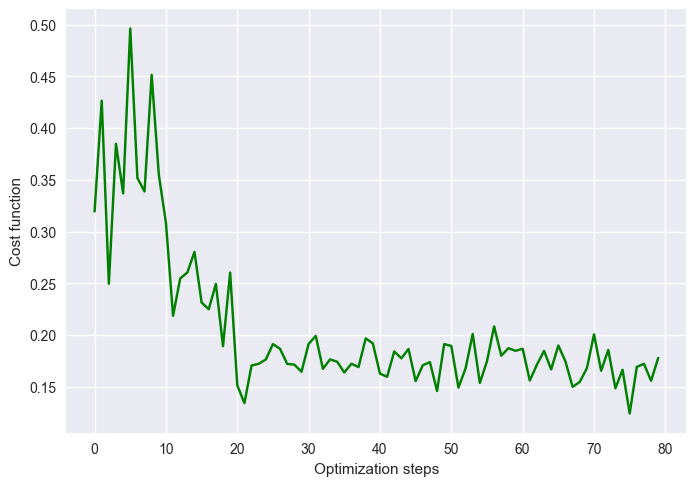

In [13]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [ ]:
# Classically finding the solution for our system

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
m_num = 1
c = c_all[m_num]
A = np.zeros((8,8))
for r in range(len(matrix[m_num])):
    ad = []
    for f in range(len(matrix[m_num][r])):
        switch = matrix[m_num][r][f]
        if switch == 0:
            ad += [Id]
        elif switch == 1:
            ad += [Z]
        elif switch == 2:
            ad += [X]
    A = np.add(A, c[r] * np.kron(np.kron(ad[0], ad[1]), ad[2]))

b = np.ones(8) / np.sqrt(8)

print("A = " + str(A))
print("b = " + str(b))

A_inv = np.linalg.inv(A)
x = np.dot(A_inv, b)

c_probs = (x / np.linalg.norm(x)) ** 2

A = [[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.55 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.55 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.1  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.55 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.55 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.1 ]]
b = [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [ ]:
# Now we will sample the quantum circuit with our optimized parameters to find the circuit's best guess to the solution
# and compare it with the solution we can find classicaly

def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots

NameError: name 'qml' is not defined

x_n^2 =      |<x|n>|^2 = 
0.004646          0.075131
0.015360          0.089982
0.015360          0.105127
0.464634          0.163481
0.004646          0.140022
0.015360          0.111548
0.015360          0.152779
0.464634          0.161930


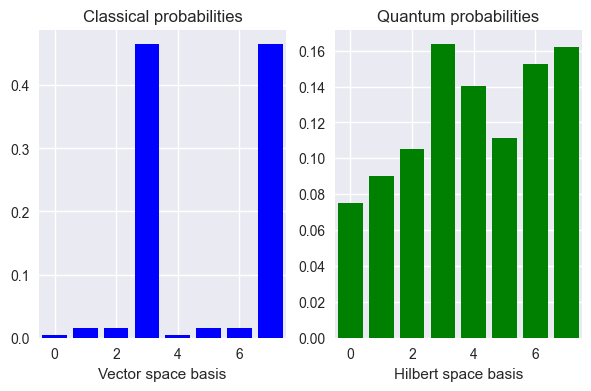

Accuracy: 1.1962167632451035


In [ ]:
print("x_n^2 =      |<x|n>|^2 = " )

for i in range(len(c_probs)):
    print("{:.6f}          {:.6f}".format(c_probs[i], q_probs[i]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

from numpy import linalg
acc = np.dot(c_probs, q_probs) / (np.linalg.norm(q_probs) ** 2)

print("Accuracy: " + str(acc))